# ACLED Data Exploration using Pyspark  

__Taken from ACLED:__ "ACLED collects real-time data on the locations, dates, actors, fatalities, and types of all reported political violence and protest events across Africa, the Middle East, Latin America & the Caribbean, East Asia, South Asia, Southeast Asia, Central Asia & the Caucasus, Europe, and the United States of America."  
LINK for more info: https://acleddata.com/#/dashboard  

##### Data is from January 1st, 2020 through to December 31st, 2020
Dataset file size: 133 mb 

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

In [17]:
spark = SparkSession.builder.appName("acledPyspark").getOrCreate()

In [18]:
df = spark.read.csv(
    path="/home/jovyan/work/notebooks/datasets/2020-01-01-2020-12-31.csv",
    sep=",",
    quote='"',
    header=True
)
df.show(5)
df.printSchema()

+-------+---+-------------+----------------+----------------+----+--------------+--------------------+--------------------+--------------------+-------------------+------+--------------------+-------------+------+-----------+--------------------+-------+----------+----------+------+-------------------+--------+---------+-------------+-------------------+-------------------+--------------------+----------+----------+----+
|data_id|iso|event_id_cnty|event_id_no_cnty|      event_date|year|time_precision|          event_type|      sub_event_type|              actor1|      assoc_actor_1|inter1|              actor2|assoc_actor_2|inter2|interaction|              region|country|    admin1|    admin2|admin3|           location|latitude|longitude|geo_precision|             source|       source_scale|               notes|fatalities| timestamp|iso3|
+-------+---+-------------+----------------+----------------+----+--------------+--------------------+--------------------+--------------------+------

### Let's see the shape of the dataframe:

In [19]:
print(df.count(), len(df.columns))

249396 31


### I want to see the "event_date" column as a string. I'll convert to a date object next:

In [20]:
df.select("event_date").show(1)

+----------------+
|      event_date|
+----------------+
|31 December 2020|
+----------------+
only showing top 1 row



### Convert date string to date type: 

In [21]:
df = df.withColumn("event_date", f.to_date("event_date", "dd MMMM yyyy"))
df.select("event_date").distinct().sort("event_date").show(5)

+----------+
|event_date|
+----------+
|2020-01-01|
|2020-01-02|
|2020-01-03|
|2020-01-04|
|2020-01-05|
+----------+
only showing top 5 rows



### Now we can do a groupBy date to see the busiest days in the ACLED dataset: 

In [82]:
# events_per_day 
events_per_day = df.groupBy("event_date").agg(
    f.count("*").alias("events_per_day")
).sort("event_date")
events_per_day.show(5, truncate=False)

+----------+--------------+
|event_date|events_per_day|
+----------+--------------+
|2020-01-01|447           |
|2020-01-02|463           |
|2020-01-03|563           |
|2020-01-04|543           |
|2020-01-05|555           |
+----------+--------------+
only showing top 5 rows



In [30]:
# Converting spark data frame so we can chart it below 
import pandas as pd
events_per_day_pandas_df = events_per_day.toPandas()

In [60]:
events_per_day_pandas_df['event_date'] = pd.to_datetime(events_per_day_pandas_df['event_date'], yearfirst=True)

<AxesSubplot:xlabel='event_date', ylabel='events_per_day'>

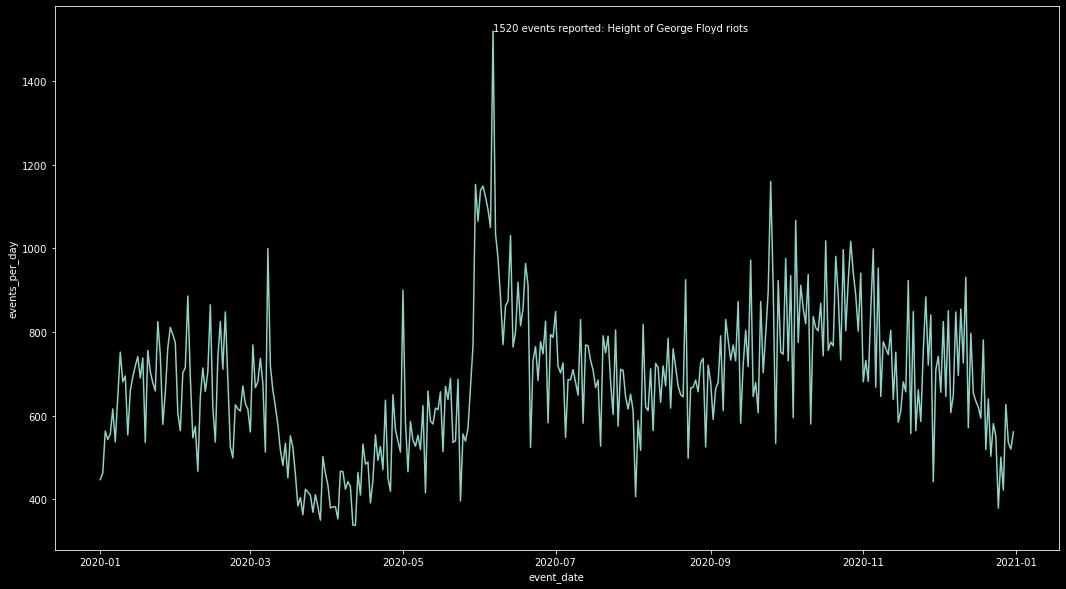

In [72]:
from matplotlib import pyplot 
import numpy as np
import seaborn as sns
pyplot.style.use("dark_background")
fig,ax = plt.subplots()
fig.set_size_inches(18, 10)
ax.annotate("1520 events reported: Height of George Floyd riots", xy=(np.datetime64('2020-06-06'),1520))
sns.lineplot(x="event_date", y="events_per_day", data=events_per_day_pandas_df)

### Further analysis on June 6, 2020: grouping the number of events reported on June 6 by country:

In [83]:
df.filter(df.event_date == '2020-06-06') \
.select("country", "event_type") \
.groupBy("country").agg(
    f.count("*").alias("number_of_june_6_events_reported_per_country") 
) \
.sort("number_of_june_6_events_reported_per_country", ascending=False) \
.show(10)

+--------------+--------------------------------------------+
|       country|number_of_june_6_events_reported_per_country|
+--------------+--------------------------------------------+
| United States|                                         745|
|         Italy|                                          93|
|       Germany|                                          66|
|United Kingdom|                                          61|
|        France|                                          45|
|      Pakistan|                                          42|
|         Yemen|                                          36|
|        Mexico|                                          32|
|       Ukraine|                                          28|
|       Lebanon|                                          27|
+--------------+--------------------------------------------+
only showing top 10 rows



### Below shows that most of the ACLED events reported on June 6th, 2020 in the US were of protests: 

In [92]:
df.groupBy("event_date", "country","event_type", ).agg(
    f.count("*").alias("number_of_events_per_type")
) \
.where(df.country == 'United States') \
.where(df.event_date == '2020-06-06') \
.sort("number_of_events_per_type", ascending=False) \
.show(truncate=False)

+----------+-------------+----------------------+-------------------------+
|event_date|country      |event_type            |number_of_events_per_type|
+----------+-------------+----------------------+-------------------------+
|2020-06-06|United States|Protests              |724                      |
|2020-06-06|United States|Strategic developments|12                       |
|2020-06-06|United States|Riots                 |8                        |
|2020-06-06|United States|Battles               |1                        |
+----------+-------------+----------------------+-------------------------+



### Making a locations dataframe: 

In [84]:
df.select("iso", "country", "region", "location", "latitude", "longitude").show(10)

+---+-----------+--------------------+-------------------+--------+---------+
|iso|    country|              region|           location|latitude|longitude|
+---+-----------+--------------------+-------------------+--------+---------+
|376|     Israel|         Middle East|               Arad| 31.2588|  35.2128|
|268|    Georgia|Caucasus and Cent...|         Tskhinvali| 42.2276|  43.9686|
|706|    Somalia|      Eastern Africa|Mogadishu - Daynile|  2.0581|  45.3003|
|376|     Israel|         Middle East|             Ashdod| 31.7921|  34.6497|
|368|       Iraq|         Middle East|       At Tarabshah| 33.5369|  43.1077|
|  4|Afghanistan|Caucasus and Cent...|            Baharak| 37.0025|  70.9066|
|  4|Afghanistan|Caucasus and Cent...|             Washir| 32.2522|  63.8531|
|275|  Palestine|         Middle East|               Gaza|    31.5|  34.4667|
| 68|    Bolivia|       South America|             Tarija|-21.5355| -64.7296|
|376|     Israel|         Middle East|           Ashqelon| 31.66